# Preparing Language Data Set

Consists of the following steps:

* Section 1: Importing necessary tools


* Section 2: Collecting raw data file from individual API exports


* Section 3: Cleaning data
    * Altering necessary feature dtypes & names
    * De-duplicating headlines 
    * Removing nulls
    * Removing unnecessary features
    * Removing erroneous headlines based on abnormal word counts (EDA)
    * Identifying & filtering to top news sections (EDA)
    * Adding custom date features for analysis


* Section 4: Applying vaderSentiment & polarity scores   


* Section 5: EDA
    * High-level plots
    * Exploring score 'migrations' over time


* Section 6: Analysis I (News Section Hypothesis Testing)
    * Visualizing trends across news sections
    * Linear Regressions across news sections


* Section 7: Analysis II (Single Section Deep Dive & Vectorization)
    * Overall 'scorecard' / high-level views
    * Vectorizing / tokenizing news section data subsets
    * Identifying top / bottom tokens
    * Identifying top / bottom headlines

## Section 1: Importing necessary tools

Downloading proper packages for general data manipulation:

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

For NLP and sentiment / polarity assignment, installing Vader Sentiment and Natural Language Tool Kit:

In [30]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


Importing analyzers from Vader Sentiment & NLTK:

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [33]:
import nltk 
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Jane/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Section 2: Collecting raw data file from monthly API exports

Reading in & union-ing all monthy files:

In [189]:
df_jan = pd.read_csv('API Data/January 1981-2021.csv')

In [ ]:
df_jan = pd.read_csv('API Data/January 1981-2021.csv')
df_feb = pd.read_csv('API Data/February 1981-2021.csv')
df_mar = pd.read_csv('API Data/March 1981-2021.csv')
df_apr = pd.read_csv('API Data/April 1981-2021.csv')
df_may = pd.read_csv('API Data/May 1981-2021.csv')
df_jun = pd.read_csv('API Data/June 1981-2021.csv')
df_jul = pd.read_csv('API Data/July 1981-2021.csv')
df_aug = pd.read_csv('API Data/August 1981-2021.csv')
df_sep = pd.read_csv('API Data/September 1981-2021.csv')
df_oct = pd.read_csv('API Data/October 1981-2021.csv')
df_nov = pd.read_csv('API Data/November 1981-2021.csv', dtype={'snippet': 'object'})
df_dec = pd.read_csv('API Data/December 1981-2021.csv')

In [190]:
df_raw = pd.concat([df_jan, df_feb, df_mar, df_apr, df_may, df_jun, df_jul, df_aug, df_sep, df_oct, df_nov, df_dec])

In [191]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3945283 entries, 0 to 312343
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   headline.main   object 
 1   pub_date        object 
 2   section_name    object 
 3   word_count      float64
 4   lead_paragraph  object 
 5   abstract        object 
 6   snippet         object 
 7   web_url         object 
dtypes: float64(1), object(7)
memory usage: 270.9+ MB


In [192]:
#initial shape
df_raw.shape

(3945283, 8)

## Section 3: Cleaning data

#### Cleaning up data structure, nulls, duplicates, unnecessary features:

In [193]:
#changing column title of headline.main
df_raw.rename(columns = {'headline.main':'headline'}, inplace = True)

#changing pub_date to date dtype
df_raw['pub_date'] = pd.to_datetime(df_raw['pub_date'])

#extracting month and year from pub_date
df_raw['year'] = df_raw['pub_date'].dt.year
df_raw['month'] = df_raw['pub_date'].dt.month

In [194]:
#dropping pub_date now that month and year extracted + other columns
df_raw = df_raw.drop(columns=['pub_date', 'word_count', 'lead_paragraph', 'abstract', 'snippet','web_url'])

In [195]:
#dropping NAs
df_raw.dropna(subset=['headline','month','year','section_name'],inplace=True)

In [196]:
#dropping duplicate headlines
df_raw.drop_duplicates(subset='headline', keep = 'first', inplace = True) 

In [197]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3369965 entries, 0 to 312343
Data columns (total 4 columns):
 #   Column        Dtype  
---  ------        -----  
 0   headline      object 
 1   section_name  object 
 2   year          float64
 3   month         float64
dtypes: float64(2), object(2)
memory usage: 128.6+ MB


In [198]:
df_raw.shape
#(3369965, 4)

(3369965, 4)

In [199]:
print(f'{round((3366339/3941484),2)*100}% of initial df_raw rows remaining')

85.0% of initial df_raw rows remaining


#### Identifying and filtering to top news sections:

In [200]:
#identifying top news sections
df_news_categories_count = df_raw['section_name'].value_counts()
top10_cat_count = df_news_categories_count.head(15) #14 including Archives
top10_cat_count

Business Day       596809
New York           420929
U.S.               327291
Sports             325222
World              298174
Opinion            269422
Arts               221173
Archives           107106
Style               94791
Books               72526
Movies              48998
Travel              44356
Technology          43900
Magazine            42001
Fashion & Style     41994
Name: section_name, dtype: int64

In looking at above list, will not be analyzing `Archives` because it is more of a catch-all section used in the past, also looked into sections beyond the top 10, e.g. `Technology` and saw that they did not have consistent content during the time period.

In [201]:
#filtering df_raw to top news sections
top10_cat_list = ['New York', 'Business Day', 'Opinion', 'U.S.', 'World', #standard news sections
                  'Sports', 'Arts', 'Style','Books', 'Movies']            #'lifestyle' sections
df_top10 = df_raw[df_raw['section_name'].isin(top10_cat_list)]
df_all = df_top10.reset_index().drop(['index'], axis=1)

In [202]:
df_all.shape
#(2675335, 4)

(2675335, 4)

In [203]:
print(f'{round((2672672/3941484),2)*100}% of initial df_raw rows remaining')

68.0% of initial df_raw rows remaining


#### Cleaning headlines by length:

In [204]:
#adding length to df
df_all['len'] = df_all['headline'].str.len()

In [205]:
#taking a look at shorter headlines:
df_all[df_all['len']<=10]

,headline,section_name,year,month,len
4566,Carne,Opinion,2021.0,1.0,5
4644,White Riot,Opinion,2021.0,1.0,10
5013,D.I.Why?,Books,2021.0,1.0,8
8724,Privacy,Opinion,2020.0,1.0,7
8725,My Phones,Opinion,2020.0,1.0,9
...,...,...,...,...,...
2673863,"BRIEFING ,",U.S.,1981.0,12.0,10
2673912,Mud,Opinion,1981.0,12.0,3
2674060,P.O.O.R.,Opinion,1981.0,12.0,8
2674224,Robot,New York,1981.0,12.0,5


In [206]:
#taking a look at longer headlines:
pd.set_option('display.max_colwidth', None) #to see full headline
df_all[df_all['len']>=200]

,headline,section_name,year,month,len
117528,"Coin Society Seeks Happiness Downtown To the Editor: Re ''Coin Society's Plans Upset Some Members'' (Arts & Ideas, Jan. 8): You accurately describe the difficult situation that the American Numismatic Society is facing. I would like to expand on why we are moving to Lower Manhattan.",Opinion,2000.0,1.0,287
136635,"Results PlusKafelnikov Takes Title in Australia Top-seeded and sixth-ranked Yevgeny Kafelnikov defeated Byron Black, seeded eighth, 7-6, (7-0), 3-6, 6-1, in the final of the Australian Hardcourt in Adelaide. It was the second time in three years Kafelnikov won the title. Black, a doubles expert who is ranked 40th in singles, said his effort in winning the second set cost him energy in the final set. (AP) KORDA CAPTURES QATAR OPEN: Petr Korda of the Czech Republic beat Younes el-Aynaoui of Morocco, 7-6 (7-5), 2-6, 7-6 (7-5), to win the Qatar Open in Doha. It was the 27-year-old Czech's seventh career title and came just three months after a hernia operation to cure him of a nagging groin injury that bothered him for 18 months. Korda's ranking will move from 41 to 27 today. El Aynaoui, who defeated top-seeded Thomas Muster in the semifinals, had only appeared in one final before, in Casablanca in 1993. (AP) TRACK AND FIELD Long Island Runner a Double Winner Rob Hiller of Farmingdale, L.I., captured the 1,500-meter (4 minutes 21.6 seconds) and 3,000-meter (9:33.7) runs yesterday in the Metropolitan Athletics Congress high school track events at Fairleigh Dickinson University in Teaneck, N.J. Three other Long Island athletes won in girls' competition. Ronale McKenzie of St. John the Baptist took the 55 meters in 7.9 seconds, teammate Lynn Merjuck was first in the 1,500 in 5:33.4, and Rose Suener of Great Neck North won the 800 in 3:00.3. The open events were canceled because to the weather. MEET RECORDS FALL AT DARTMOUTH RELAYS: Bruny Surin of Canada and Cheryl Brantle of Boston set meet records in the 55-meter dashes at the Dartmouth Relays in Hanover, N.H. Surin, the world indoor champion, broke his 1993 mark of 6.17 seconds by winning his semifinal heat in 6.15. Surin then won the final in 6.16. Brantle won the women's final in 6.93, breaking her 1993 meet record of 6.95. Rebecca Grube of the Boston Athletic Association set a meet record in the long jump with a leap of 20 feet 3 3/4 inches. (AP) SKIING Tomba Wins Third Straight Slalom Alberto Tomba, the three-time Olympic gold medalist, won in Flachau, Austria, yesterday to take his third consecutive World Cup slalom race. He was timed in 1 minute 41.05 seconds. Mario Reiter of Austria, who led Tomba by .36 seconds after the first run, finished second at 1:41.25. At this time last year, Tomba had won five slaloms and two giant slaloms en route to 11 victories during the 1994-95 season. (A",Sports,1996.0,1.0,2495
138707,"DRIVING;Trouble SpotsA look at trouble spots you may encounter in the next week -- or month, or months -- courtesy of Transcom, an interstate transportation agency. 1. INTERSTATE 80 Lodi. The crossover from the local lanes to the express lanes is closed until further notice. 2. ROUTES 1 and 9 Essex. Southbound traffic is shifted to northbound express lanes between the Pulaski Skyway and Interstate 78. The Wilson Avenue exit is closed. Until further notice. 3. EAST HOBART GAP ROAD Essex County, between J. F. K. Parkway and Canoe Brook Drive. Road closed for bridge replacement until further notice. Detour posted. 4. ROUTE 22 Kenilworth, Union County. One eastbound lane closed at Michigan Avenue. Monday through Friday, 9 A.M. to 4 P.M., through Feb. 12. 5. ROUTE 1 Plainsboro. The Princeton-Plainsboro Road bridge is closed until Jan. 31. Use Scudders Mill Road. 6. ROUTE 1 West Windsor. Northbound shoulder lane closed between Nassau Park Boulevard and Alexander Road until further notice. Expect delays.",New York,1996.0,1.0,1012
149499,"Those Old Cliches To the Editor: In his review of ""The Complete Lyrics of Ir

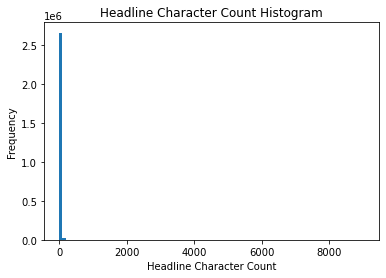

In [207]:
#plotting lengths against headline counts

plt.figure()
plt.hist(df_all['len'], bins=100)
plt.xlabel('Headline Character Count')
plt.ylabel('Frequency')
plt.title('Headline Character Count Histogram')
plt.show()

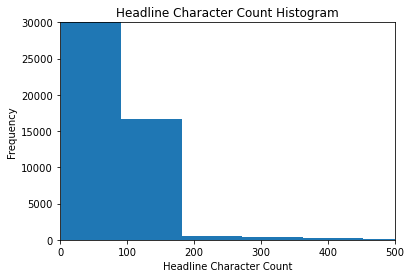

In [208]:
#a closer look at the headline length plot:

plt.figure()
plt.hist(df_all['len'], bins=100)
plt.xlabel('Headline Character Count')
plt.ylabel('Frequency')
plt.title('Headline Character Count Histogram')
plt.xlim([0,500])
plt.ylim([0,30000])
plt.show()

In [209]:
#removing headlines that are too short
df_all_remove_short = df_all[df_all['len']>10]

#removing headlines that are too long
df_all_remove_long = df_all_remove_short[df_all_remove_short['len']<=175]

#dropping length column
df_all = df_all_remove_long.drop(columns='len')

In [210]:
df_all.shape

(2666088, 4)

In [211]:
print(f'{round((2663424/3941484),2)*100}% of initial df_raw rows remaining')

68.0% of initial df_raw rows remaining


#### Adding custom date features for analysis (5-year & decades):

In [212]:
#creating year groups of 5
year_group = []

for x in df_all['year']:
    if x <1985: year_group.append('1')
    elif x <1990: year_group.append('2')
    elif x <1995: year_group.append('3')
    elif x <2000: year_group.append('4')
    elif x <2005: year_group.append('5')
    elif x <2010: year_group.append('6')
    elif x <2015: year_group.append('7')
    elif x <2020: year_group.append('8')
    elif x <2025: year_group.append('9')
    else: year_group.append('0')

In [213]:
df_all['year_group'] = year_group

In [214]:
#creating year groups of 10
decade = []

for x in df_all['year']:
    if x <1990: decade.append('1')
    elif x <2000: decade.append('2')
    elif x <2010: decade.append('3')
    elif x <2020: decade.append('4')
    elif x <2030: decade.append('5')
    else: decade.append('0')

In [215]:
df_all['decade'] = decade

In [216]:
#changing dtype of created features
df_all = df_all.astype({'year_group':'int'})
df_all = df_all.astype({'decade':'int'})

In [219]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666088 entries, 0 to 2675334
Data columns (total 6 columns):
 #   Column        Dtype  
---  ------        -----  
 0   headline      object 
 1   section_name  object 
 2   year          float64
 3   month         float64
 4   year_group    int64  
 5   decade        int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 142.4+ MB


## Section 4: Applying vaderSentiment & polarity scores

Calculating & appending polarity scores:

In [220]:
df_all['compound'] = [analyzer.polarity_scores(x)['compound'] for x in df_all['headline']]
df_all['neg'] = [analyzer.polarity_scores(x)['neg'] for x in df_all['headline']]
df_all['neu'] = [analyzer.polarity_scores(x)['neu'] for x in df_all['headline']]
df_all['pos'] = [analyzer.polarity_scores(x)['pos'] for x in df_all['headline']]

In [221]:
# 4 vaderSentiment scores added to df:
df_all.info()

#Int64Index: 2666088 entries, 0 to 2675334
#Data columns (total 10 columns):

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666088 entries, 0 to 2675334
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   headline      object 
 1   section_name  object 
 2   year          float64
 3   month         float64
 4   year_group    int64  
 5   decade        int64  
 6   compound      float64
 7   neg           float64
 8   neu           float64
 9   pos           float64
dtypes: float64(6), int64(2), object(2)
memory usage: 223.7+ MB


In [222]:
df_all.head(5)

,headline,section_name,year,month,year_group,decade,compound,neg,neu,pos
0,"Alabama Rolls Past Cincinnati, 27-6, in College Football Playoff Semifinal",Sports,2022.0,1.0,9,5,0.0000,0.0,1.000,0.000
1,People Magazine’s Premature Cover Toasts Betty White’s 100th Birthday,Business Day,2022.0,1.0,9,5,0.0000,0.0,1.000,0.000
2,Betty White Recalled as a Trailblazer With a Love for Life,Arts,2022.0,1.0,9,5,0.6369,0.0,0.704,0.296
3,A Renewed Georgia Pummels Michigan to Reach National Title Game vs. Alabama,Sports,2022.0,1.0,9,5,0.0258,0.0,0.909,0.091
4,"The Rise of Daily Run Streakers. No, Not Those Streakers.",Sports,2022.0,1.0,9,5,0.0000,0.0,1.000,0.000


## Section 5: EDA

#### High-level plots/trends:

Look at volume of headlines by month over time (mostly from QA to be sure that import from API went well):

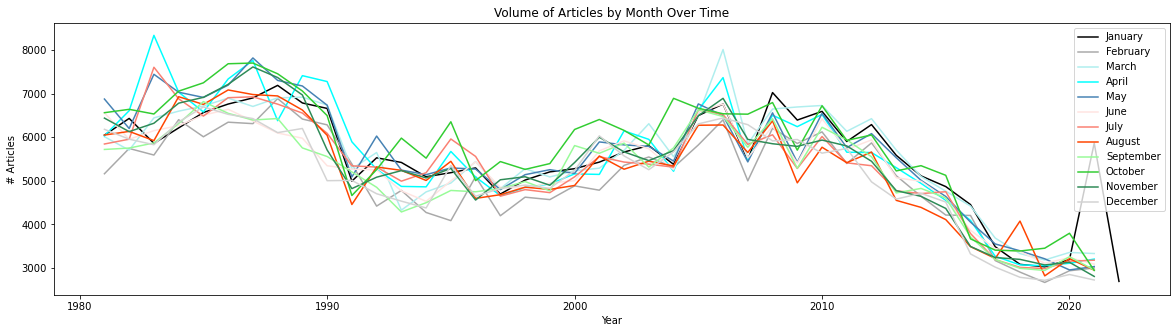

In [223]:
#creating df with volume of articles by month & year
df_headlines_by_year = df_all[['year','month']].value_counts().sort_index().unstack('month')

#plotting this df
plt.figure(figsize = (20,5))
plt.plot(df_headlines_by_year.index, df_headlines_by_year[1], c='black', label = 'January')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[2], c='darkgrey', label = 'February')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[3], c='paleturquoise', label = 'March')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[4], c='aqua', label = 'April')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[5], c='steelblue', label = 'May')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[6], c='mistyrose', label = 'June')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[7], c='salmon', label = 'July')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[8], c='orangered', label = 'August')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[9], c='palegreen', label = 'September')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[10], c='limegreen', label = 'October')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[11], c='seagreen', label = 'November')
plt.plot(df_headlines_by_year.index, df_headlines_by_year[12], c='lightgrey', label = 'December')
plt.xlabel('Year')
plt.ylabel('# Articles')
plt.title('Volume of Articles by Month Over Time')
plt.legend()
plt.show()

Looking at net sentiment over time:

In [224]:
#assigning score of negative, neutral, or positive based on compound value: 
score = []

for x in df_all['compound']:
    if x == 0: score.append('neutral')
    elif x < 0: score.append('negative')
    elif x > 0: score.append('positive')
    else: score.append('0')

df_all['score'] = score

In [225]:
#[score] feature added to df
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2666088 entries, 0 to 2675334
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   headline      object 
 1   section_name  object 
 2   year          float64
 3   month         float64
 4   year_group    int64  
 5   decade        int64  
 6   compound      float64
 7   neg           float64
 8   neu           float64
 9   pos           float64
 10  score         object 
dtypes: float64(6), int64(2), object(3)
memory usage: 244.1+ MB


In [226]:
#creating df that shows volume of scores by year
df_scores_by_year = df_all.groupby(['year','score']).count()['headline'].unstack('score')
df_scores_by_year['total']=df_scores_by_year['negative']+df_scores_by_year['neutral']+df_scores_by_year['positive']

In [227]:
#adding on columns that calculate % to complement volumes with share 
df_scores_by_year['neg%']=df_scores_by_year['negative']/df_scores_by_year['total']
df_scores_by_year['pos%']=df_scores_by_year['positive']/df_scores_by_year['total']
df_scores_by_year['neu%']=df_scores_by_year['neutral']/df_scores_by_year['total']

In [228]:
df_scores_by_year.tail(5)

score,negative,neutral,positive,total,neg%,pos%,neu%
year,,,,,,,
2018.0,12649,16851,9138,38638,0.327372,0.236503,0.436125
2019.0,12171,15409,8677,36257,0.335687,0.239319,0.424994
2020.0,12297,16674,9239,38210,0.321827,0.241795,0.436378
2021.0,13382,16571,9140,39093,0.342312,0.233801,0.423887
2022.0,850,1165,679,2694,0.315516,0.252042,0.432442


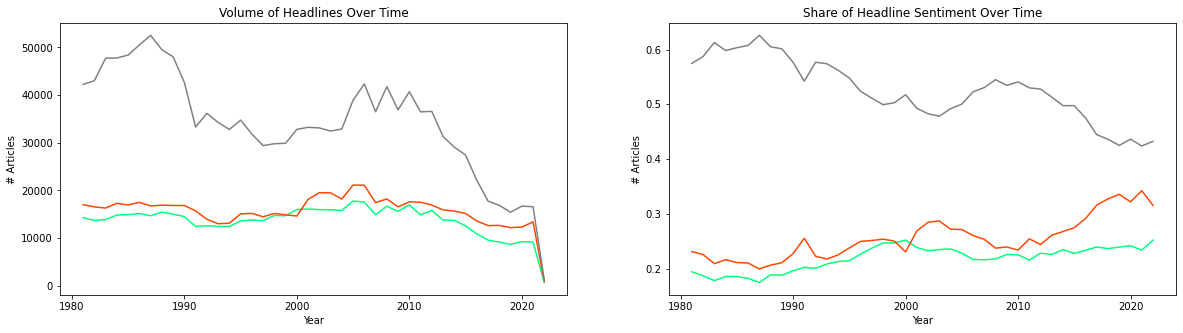

In [229]:
plt.subplots(1,2, figsize=(20,5))

#plotting volume columns
plt.subplot(1,2,1)
plt.plot(df_scores_by_year.index, df_scores_by_year['positive'], c='springgreen', label = 'positive')
plt.plot(df_scores_by_year.index, df_scores_by_year['negative'], c='orangered', label = 'negative')
plt.plot(df_scores_by_year.index, df_scores_by_year['neutral'], c='grey', label = 'neutral')
plt.xlabel('Year')
plt.ylabel('# Articles')
plt.title('Volume of Headlines Over Time')

#plotting share columns
plt.subplot(1,2,2)
plt.plot(df_scores_by_year.index, df_scores_by_year['pos%'], c='springgreen')
plt.plot(df_scores_by_year.index, df_scores_by_year['neg%'], c='orangered')
plt.plot(df_scores_by_year.index, df_scores_by_year['neu%'], c='grey')
plt.xlabel('Year')
plt.ylabel('# Articles')
plt.title('Share of Headline Sentiment Over Time')

plt.show()

#### Exploring score migrations over time:

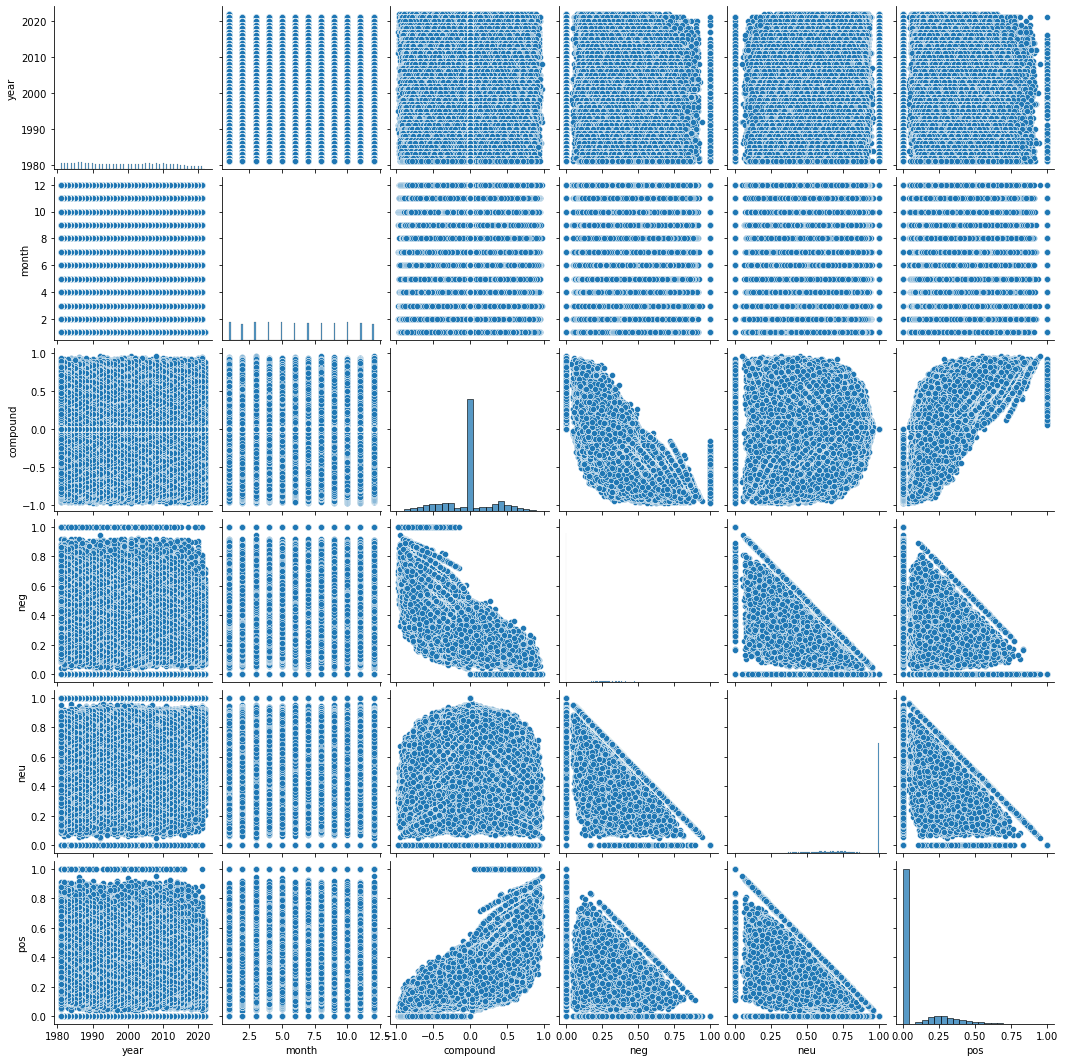

In [230]:
sns.pairplot(data=df_all.drop(columns=['year_group','decade','section_name','headline']))
plt.show()

More than anything that above tells me about the relationships between the vaderSentiment polarity scores -- higher negative means lower compound, higher positive means higher compound -- this is intuitive to how the tool works. With each other, the scores (neutral, negative, positive) stay within certains and are always weighed against each other. E.g. a headline cannot have .6 negativity and .6 positivity -- same with neutrality it must sway one way or the other on the spectrum. This tells me that the way vaderSentiment calculates these scores is not independent of each other but the exact opposite.

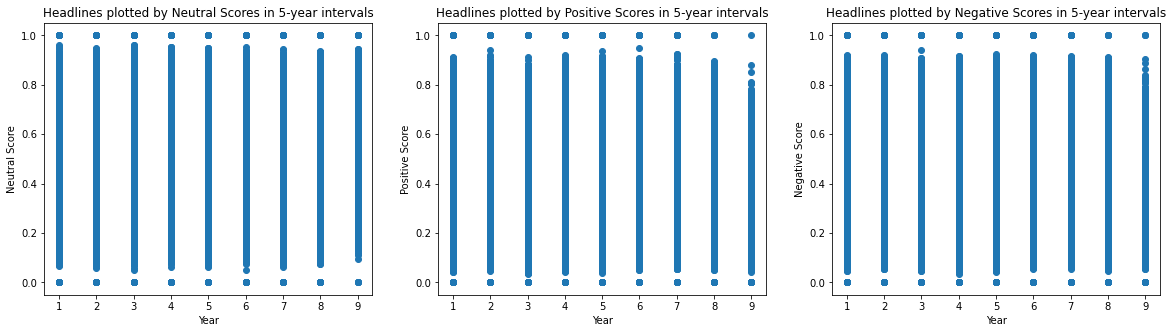

In [231]:
#first trying scatter plots to map the scores individually against the years
#reminder that 'year_group' column is in groups of 5 (e.g. 1 is 1981-1985, and 8 is 2015-2019, 9 is 2020-2021)

plt.subplots(1,3, figsize=(20,5))

plt.subplot(1,3,1)
plt.scatter(df_all['year_group'], df_all['neu'])
plt.xlabel('Year')
plt.ylabel('Neutral Score')
plt.title('Headlines plotted by Neutral Scores in 5-year intervals')

plt.subplot(1,3,2)
plt.scatter(df_all['year_group'], df_all['pos'])
plt.xlabel('Year')
plt.ylabel('Positive Score')
plt.title('Headlines plotted by Positive Scores in 5-year intervals')

plt.subplot(1,3,3)
plt.scatter(df_all['year_group'], df_all['neg'])
plt.xlabel('Year')
plt.ylabel('Negative Score')
plt.title('Headlines plotted by Negative Scores in 5-year intervals')

plt.show()

<AxesSubplot:xlabel='decade', ylabel='neu'>

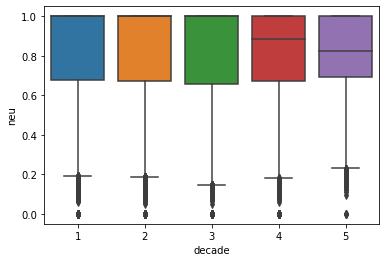

In [232]:
sns.boxplot(x="decade", y="neu", data=df_all)

<AxesSubplot:xlabel='decade', ylabel='pos'>

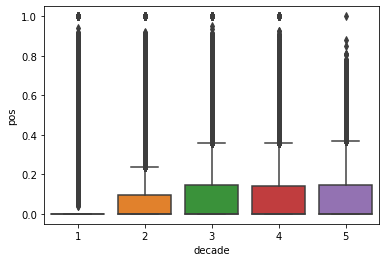

In [233]:
sns.boxplot(x="decade", y="pos", data=df_all)

<AxesSubplot:xlabel='decade', ylabel='neg'>

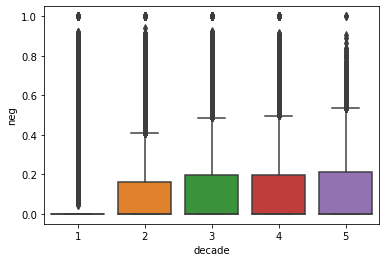

In [234]:
sns.boxplot(x="decade", y="neg", data=df_all)

From the boxplots I can see some shifts: growth in negative distribution over decade, some growth in positive but then stability, some decrease in neutral. Ultimately, I want to be able to show this to an audience in a more interpretation-friendly way, so I'm going to try to do a similar lok that focuses on distribution but is a bit simpler, histograms:

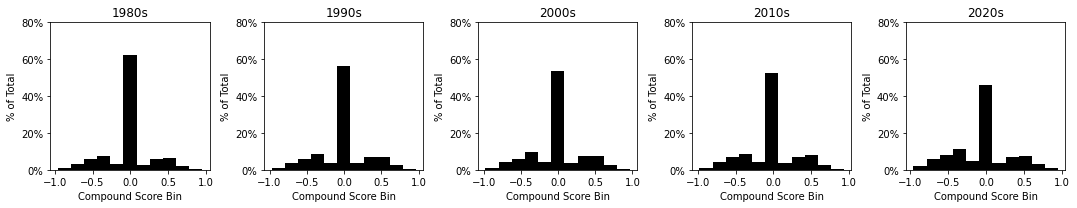

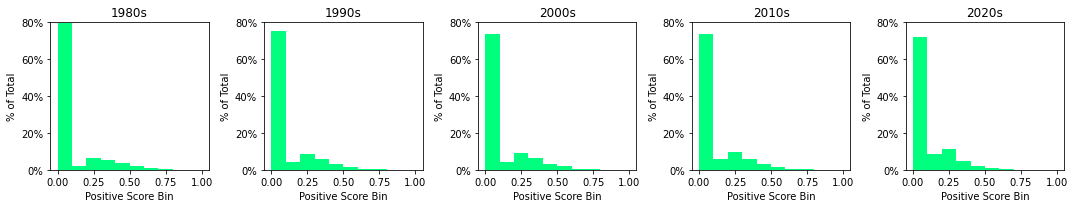

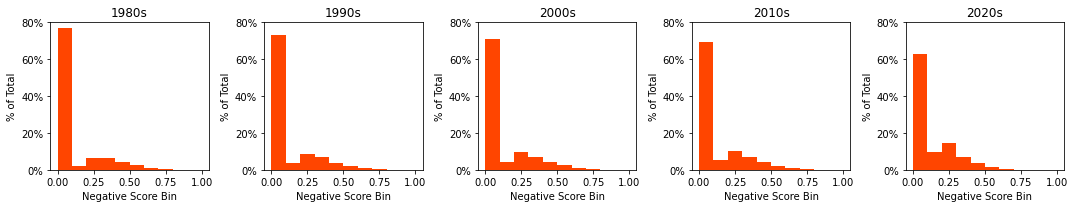

In [235]:
from matplotlib.ticker import PercentFormatter

#graphing compound scores by decade

plt.subplots(1,5, figsize=(15,3))

cmp1 = df_all[df_all['decade']==1]['compound']
cmp2 = df_all[df_all['decade']==2]['compound']
cmp3 = df_all[df_all['decade']==3]['compound']
cmp4 = df_all[df_all['decade']==4]['compound']
cmp5 = df_all[df_all['decade']==5]['compound']

plt.subplot(1,5,1)
plt.hist(cmp1, weights=np.ones(len(cmp1))/len(cmp1),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('1980s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,2)
plt.hist(cmp2, weights=np.ones(len(cmp2))/len(cmp2),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('1990s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,3)
plt.hist(cmp3, weights=np.ones(len(cmp3))/len(cmp3),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('2000s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,4)
plt.hist(cmp4, weights=np.ones(len(cmp4))/len(cmp4),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('2010s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,5)
plt.hist(cmp5, weights=np.ones(len(cmp5))/len(cmp5),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('2020s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()



#graphing positive scores by decade

plt.subplots(1,5, figsize=(15,3))

pos1 = df_all[df_all['decade']==1]['pos']
pos2 = df_all[df_all['decade']==2]['pos']
pos3 = df_all[df_all['decade']==3]['pos']
pos4 = df_all[df_all['decade']==4]['pos']
pos5 = df_all[df_all['decade']==5]['pos']

plt.subplot(1,5,1)
plt.hist(pos1, weights=np.ones(len(pos1))/len(pos1),bins=10, color = 'springgreen')
plt.xlabel('Positive Score Bin')
plt.ylabel('% of Total')
plt.title('1980s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,2)
plt.hist(pos2, weights=np.ones(len(pos2))/len(pos2),bins=10, color = 'springgreen')
plt.xlabel('Positive Score Bin')
plt.ylabel('% of Total')
plt.title('1990s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,3)
plt.hist(pos3, weights=np.ones(len(pos3))/len(pos3),bins=10, color = 'springgreen')
plt.xlabel('Positive Score Bin')
plt.ylabel('% of Total')
plt.title('2000s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,4)
plt.hist(pos4, weights=np.ones(len(pos4))/len(pos4),bins=10, color = 'springgreen')
plt.xlabel('Positive Score Bin')
plt.ylabel('% of Total')
plt.title('2010s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,5)
plt.hist(pos5, weights=np.ones(len(pos5))/len(pos5),bins=10
        , color = 'springgreen')
plt.xlabel('Positive Score Bin')
plt.ylabel('% of Total')
plt.title('2020s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()



#graphing negative scores by decade 

plt.subplots(1,5, figsize=(15,3))

neg1 = df_all[df_all['decade']==1]['neg']
neg2 = df_all[df_all['decade']==2]['neg']
neg3 = df_all[df_all['decade']==3]['neg']
neg4 = df_all[df_all['decade']==4]['neg']
neg5 = df_all[df_all['decade']==5]['neg']

plt.subplot(1,5,1)
plt.hist(neg1, weights=np.ones(len(neg1))/len(neg1),bins=10, color = 'orangered')
plt.xlabel('Negative Score Bin')
plt.ylabel('% of Total')
plt.title('1980s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,2)
plt.hist(neg2, weights=np.ones(len(neg2))/len(neg2),bins=10, color = 'orangered')
plt.xlabel('Negative Score Bin')
plt.ylabel('% of Total')
plt.title('1990s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,3)
plt.hist(neg3, weights=np.ones(len(neg3))/len(neg3),bins=10, color = 'orangered')
plt.xlabel('Negative Score Bin')
plt.ylabel('% of Total')
plt.title('2000s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,4)
plt.hist(neg4, weights=np.ones(len(neg4))/len(neg4),bins=10, color = 'orangered')
plt.xlabel('Negative Score Bin')
plt.ylabel('% of Total')
plt.title('2010s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,5)
plt.hist(neg5, weights=np.ones(len(neg5))/len(neg5),bins=10, color = 'orangered')
plt.xlabel('Negative Score Bin')
plt.ylabel('% of Total')
plt.title('2020s')
plt.ylim([0,0.8])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()

This illustrates the shift / migration away from neutrality best, by grouping the headlines into order of sentiment intensity (or lack thereof). These are the views I use in my presentation.

## Section 6: Analysis I (News Section Hypothesis Testing)

#### Visualizing trends across news sections:

In [236]:
#creating df with volume of articles by news section by year
df_cat_by_year = df_all.groupby(['year','section_name']).count()['headline'].unstack('section_name')
df_cat_by_year.head()

section_name,Arts,Books,Business Day,Movies,New York,Opinion,Sports,Style,U.S.,World
year,,,,,,,,,,
1981.0,4905,1245,16273,763,14193,5272,9236,3367,9718,8506
1982.0,4920,1182,17669,708,12239,5120,9545,3367,9453,8992
1983.0,5083,1126,23480,718,11885,5088,9789,3268,8931,8525
1984.0,6085,1670,20822,559,12376,4874,9735,3106,11911,8709
1985.0,5868,1755,20591,708,13318,5192,9519,3165,11511,8570


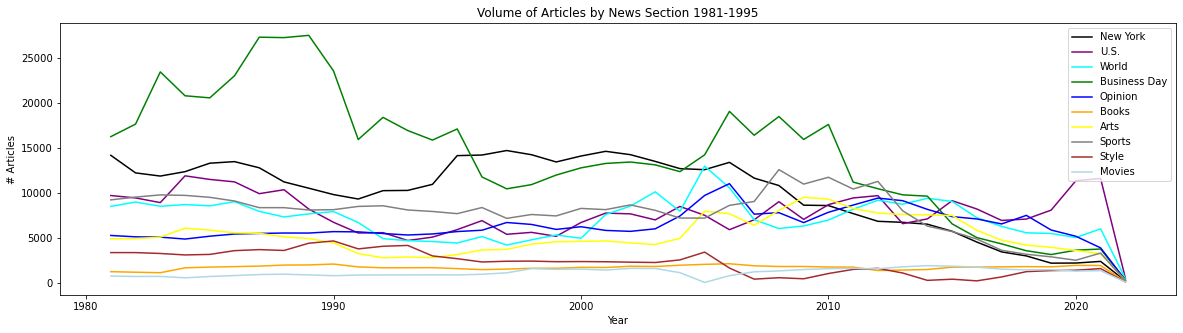

In [237]:
#plotting this df
plt.figure(figsize = (20,5))
plt.plot(df_cat_by_year.index, df_cat_by_year['New York'], c='black', label = 'New York')
plt.plot(df_cat_by_year.index, df_cat_by_year['U.S.'], c='purple', label = 'U.S.')
plt.plot(df_cat_by_year.index, df_cat_by_year['World'], c='cyan', label = 'World')
plt.plot(df_cat_by_year.index, df_cat_by_year['Business Day'], c='green', label = 'Business Day')
plt.plot(df_cat_by_year.index, df_cat_by_year['Opinion'], c='blue', label = 'Opinion')
plt.plot(df_cat_by_year.index, df_cat_by_year['Books'], c='orange', label = 'Books')
plt.plot(df_cat_by_year.index, df_cat_by_year['Arts'], c='yellow', label = 'Arts')
plt.plot(df_cat_by_year.index, df_cat_by_year['Sports'], c='gray', label = 'Sports')
plt.plot(df_cat_by_year.index, df_cat_by_year['Style'], c='brown', label = 'Style')
plt.plot(df_cat_by_year.index, df_cat_by_year['Movies'], c='lightblue', label = 'Movies')
plt.xlabel('Year')
plt.ylabel('# Articles')
plt.title('Volume of Articles by News Section 1981-1995')
plt.legend()
plt.show()

Now looking at sentiment trends within each news section:

In [238]:
#creating invidual dfs that count volume of net positive, net neutral, net negative, and total headlines against each section each year

#net neutral df
df_all_neu1 = df_all[df_all['compound']==0]
df_all_neu_year1 = df_all_neu1.groupby(['year','section_name']).size().to_frame(name = 'count_neu').reset_index()

#net positive df
df_all_pos1 = df_all[df_all['compound']>0]
df_all_pos_year1 = df_all_pos1.groupby(['year','section_name']).size().to_frame(name = 'count_pos').reset_index()

#net negative df
df_all_neg1 = df_all[df_all['compound']<0]
df_all_neg_year1 = df_all_neg1.groupby(['year','section_name']).size().to_frame(name = 'count_neg').reset_index()

#total df
df_all_total_year1 = df_all.groupby(['year','section_name']).size().to_frame(name = 'count_all').reset_index()


#merging created neutral, negative, positive, total dfs
sentiment_counts_1 = pd.merge(df_all_neu_year1, df_all_pos_year1, on=['year', 'section_name'])
sentiment_counts_2 = pd.merge(df_all_neg_year1, df_all_total_year1, on=['year', 'section_name'])

sentiment_counts = pd.merge(sentiment_counts_1, sentiment_counts_2, on=['year', 'section_name'])


#adding calculations of %s to existing counts df
sentiment_counts['pos%'] = sentiment_counts['count_pos']/sentiment_counts['count_all']*100
sentiment_counts['neg%'] = sentiment_counts['count_neg']/sentiment_counts['count_all']*100
sentiment_counts['neu%'] = sentiment_counts['count_neu']/sentiment_counts['count_all']*100

#showing final df
sentiment_counts

,year,section_name,count_neu,count_pos,count_neg,count_all,pos%,neg%,neu%
0,1981.0,Arts,3509,1020,376,4905,20.795107,7.665647,71.539246
1,1981.0,Books,786,306,153,1245,24.578313,12.289157,63.132530
2,1981.0,Business Day,11437,2704,2132,16273,16.616481,13.101456,70.282062
3,1981.0,Movies,450,184,129,763,24.115334,16.906946,58.977720
4,1981.0,New York,7460,2903,3830,14193,20.453745,26.985134,52.561122
...,...,...,...,...,...,...,...,...,...
415,2022.0,Opinion,108,88,105,301,29.235880,34.883721,35.880399
416,2022.0,Sports,103,69,46,218,31.651376,21.100917,47.247706
417,2022.0,Style,53,44,10,107,41.121495,9.345794,49.532710
418,2022.0,U.S.,205,119,215,539,22.077922,39.888683,38.033395


In [239]:
sentiment_counts[sentiment_counts['section_name']=='World']

,year,section_name,count_neu,count_pos,count_neg,count_all,pos%,neg%,neu%
9,1981.0,World,3723,1518,3265,8506,17.846226,38.384670,43.769104
19,1982.0,World,4229,1469,3294,8992,16.336744,36.632562,47.030694
29,1983.0,World,3812,1333,3380,8525,15.636364,39.648094,44.715543
39,1984.0,World,3849,1317,3543,8709,15.122287,40.682053,44.195660
49,1985.0,World,3738,1329,3503,8570,15.507585,40.875146,43.617270
59,1986.0,World,4006,1384,3644,9034,15.319903,40.336507,44.343591
69,1987.0,World,3491,1398,3063,7952,17.580483,38.518612,43.900905
79,1988.0,World,2985,1364,2984,7333,18.600845,40.692759,40.706396
89,1989.0,World,3042,1613,3023,7678,21.008075,39.372232,39.619693
99,1990.0,World,3188,1626,3118,7932,20.499244,39.309128,40.191629


In [240]:
sentiment_counts.to_csv('Sentiment Counts.csv', index=False)
#push above df to csv for visualization in Tableau!

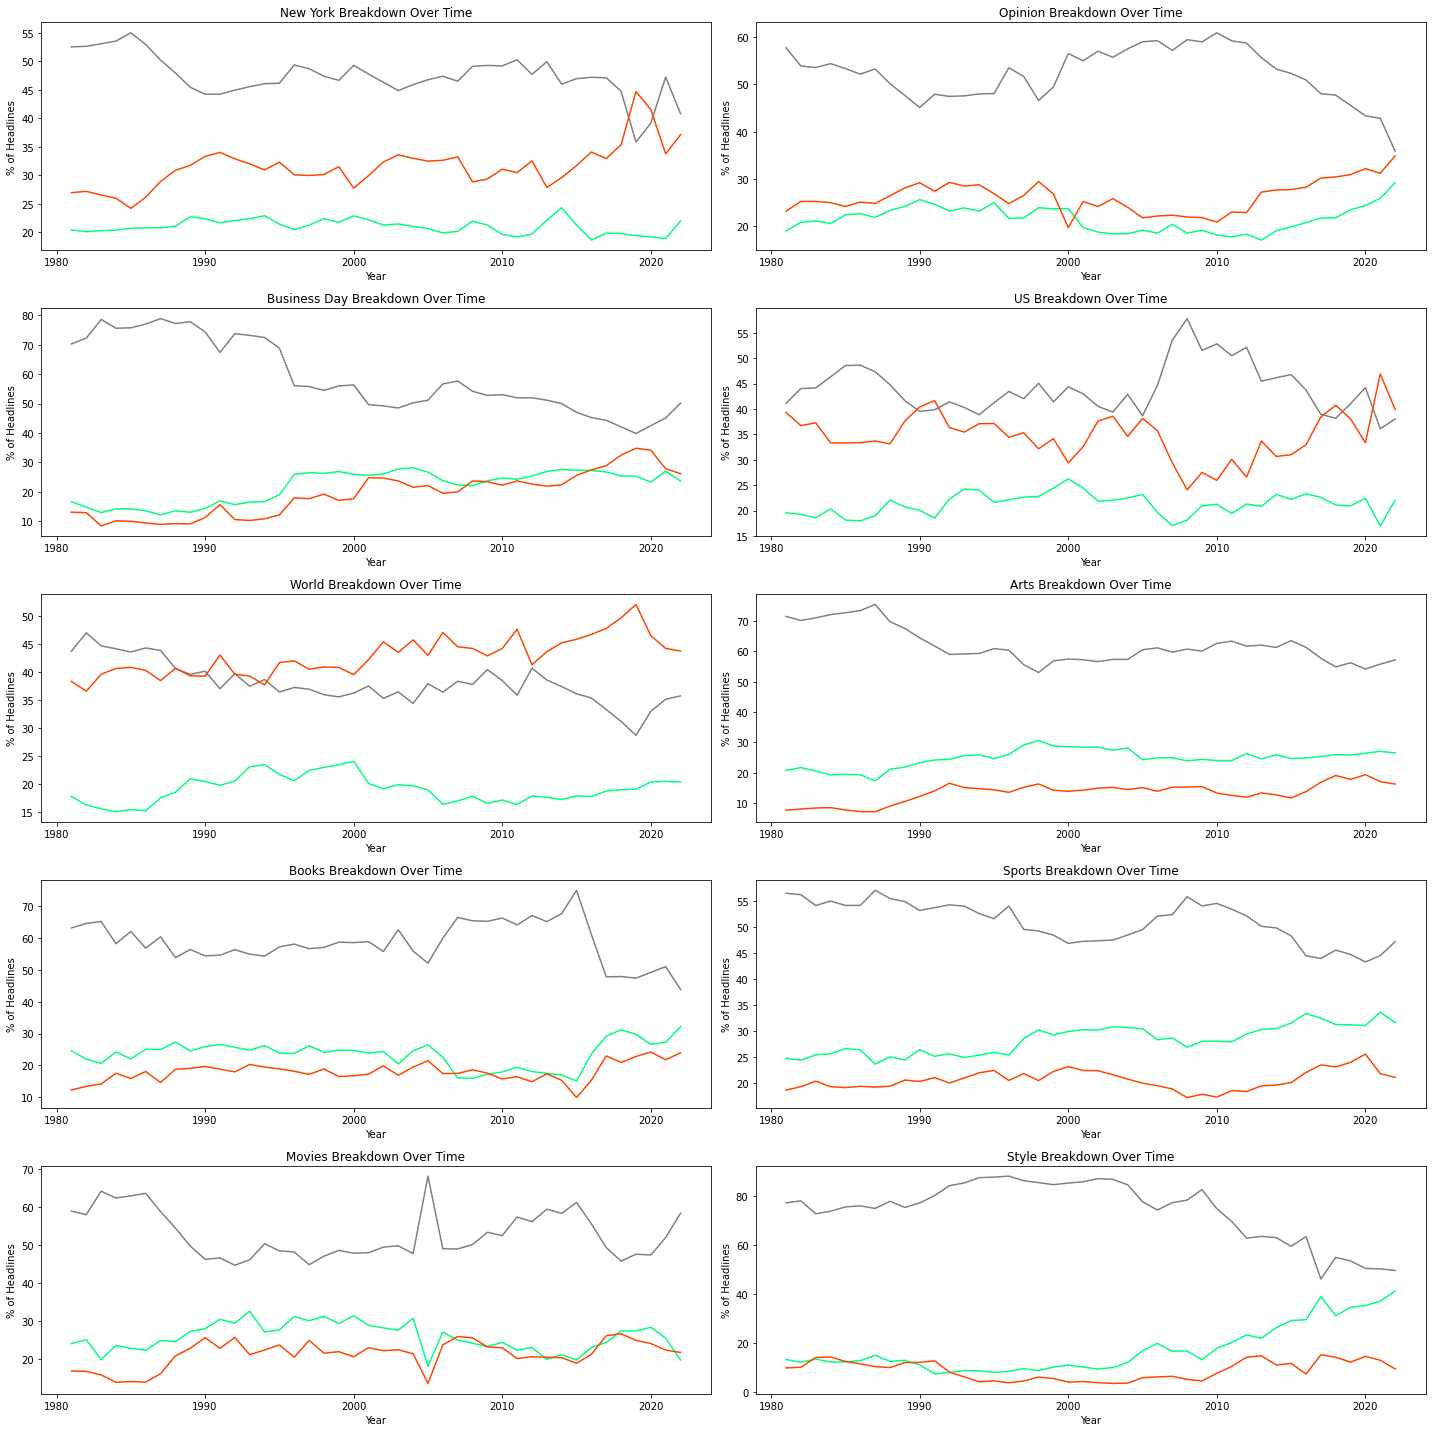

In [241]:
#graphing these sentiment trends by news section
plt.subplots(5,2, figsize=(20,20))

plt.subplot(5,2,1)
merged_nyc_dd = sentiment_counts[sentiment_counts['section_name']=='New York']
plt.plot(merged_nyc_dd['year'], merged_nyc_dd['neu%'], c='grey')
plt.plot(merged_nyc_dd['year'], merged_nyc_dd['pos%'], c='springgreen')
plt.plot(merged_nyc_dd['year'], merged_nyc_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('New York Breakdown Over Time')

plt.subplot(5,2,2)
merged_opn_dd = sentiment_counts[sentiment_counts['section_name']=='Opinion']
plt.plot(merged_opn_dd['year'], merged_opn_dd['neu%'], c='grey')
plt.plot(merged_opn_dd['year'], merged_opn_dd['pos%'], c='springgreen')
plt.plot(merged_opn_dd['year'], merged_opn_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Opinion Breakdown Over Time')

plt.subplot(5,2,3)
merged_biz_dd = sentiment_counts[sentiment_counts['section_name']=='Business Day']
plt.plot(merged_biz_dd['year'], merged_biz_dd['neu%'], c='grey')
plt.plot(merged_biz_dd['year'], merged_biz_dd['pos%'], c='springgreen')
plt.plot(merged_biz_dd['year'], merged_biz_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Business Day Breakdown Over Time')

plt.subplot(5,2,4)
merged_usa_dd = sentiment_counts[sentiment_counts['section_name']=='U.S.']
plt.plot(merged_usa_dd['year'], merged_usa_dd['neu%'], c='grey')
plt.plot(merged_usa_dd['year'], merged_usa_dd['pos%'], c='springgreen')
plt.plot(merged_usa_dd['year'], merged_usa_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('US Breakdown Over Time')

plt.subplot(5,2,5)
merged_wrl_dd = sentiment_counts[sentiment_counts['section_name']=='World']
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['neu%'], c='grey')
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['pos%'], c='springgreen')
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('World Breakdown Over Time')

plt.subplot(5,2,6)
merged_art_dd = sentiment_counts[sentiment_counts['section_name']=='Arts']
plt.plot(merged_art_dd['year'], merged_art_dd['neu%'], c='grey')
plt.plot(merged_art_dd['year'], merged_art_dd['pos%'], c='springgreen')
plt.plot(merged_art_dd['year'], merged_art_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Arts Breakdown Over Time')

plt.subplot(5,2,7)
merged_bks_dd = sentiment_counts[sentiment_counts['section_name']=='Books']
plt.plot(merged_bks_dd['year'], merged_bks_dd['neu%'], c='grey')
plt.plot(merged_bks_dd['year'], merged_bks_dd['pos%'], c='springgreen')
plt.plot(merged_bks_dd['year'], merged_bks_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Books Breakdown Over Time')

plt.subplot(5,2,8)
merged_spr_dd = sentiment_counts[sentiment_counts['section_name']=='Sports']
plt.plot(merged_spr_dd['year'], merged_spr_dd['neu%'], c='grey')
plt.plot(merged_spr_dd['year'], merged_spr_dd['pos%'], c='springgreen')
plt.plot(merged_spr_dd['year'], merged_spr_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Sports Breakdown Over Time')

plt.subplot(5,2,9)
merged_mvs_dd = sentiment_counts[sentiment_counts['section_name']=='Movies']
plt.plot(merged_mvs_dd['year'], merged_mvs_dd['neu%'], c='grey')
plt.plot(merged_mvs_dd['year'], merged_mvs_dd['pos%'], c='springgreen')
plt.plot(merged_mvs_dd['year'], merged_mvs_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Movies Breakdown Over Time')

plt.subplot(5,2,10)
merged_sty_dd = sentiment_counts[sentiment_counts['section_name']=='Style']
plt.plot(merged_sty_dd['year'], merged_sty_dd['neu%'], c='grey')
plt.plot(merged_sty_dd['year'], merged_sty_dd['pos%'], c='springgreen')
plt.plot(merged_sty_dd['year'], merged_sty_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('Style Breakdown Over Time')

plt.tight_layout()
plt.show()

From this we can see that many sections seems to follow the overall trend. Namely, `World` `US` `New York` `Opinion` `Business Day` (what I would consider more traditional news). Although some lifestyle categories also seem to experience this (`Style` `Sports`) while other lifestyle sections seem to be more affected in the recent past: `Movies` `Books` `Arts`. Will explore these correlations further:

Linear regressions across news sections:

In [242]:
# first 'traditional' news results:

# NYC results
X_nyc_neu = merged_nyc_dd['year'] # independent
y_nyc_neu = merged_nyc_dd['neu%'] # dependent

X_nyc_pos = merged_nyc_dd['year'] # independent
y_nyc_pos = merged_nyc_dd['pos%'] # dependent

X_nyc_neg = merged_nyc_dd['year'] # independent
y_nyc_neg = merged_nyc_dd['neg%'] # dependent


# World results
X_wrl_neu = merged_wrl_dd['year'] # independent
y_wrl_neu = merged_wrl_dd['neu%'] # dependent

X_wrl_pos = merged_wrl_dd['year'] # independent
y_wrl_pos = merged_wrl_dd['pos%'] # dependent

X_wrl_neg = merged_wrl_dd['year'] # independent
y_wrl_neg = merged_wrl_dd['neg%'] # dependent


# USA results
X_usa_neu = merged_usa_dd['year'] # independent
y_usa_neu = merged_usa_dd['neu%'] # dependent

X_usa_pos = merged_usa_dd['year'] # independent
y_usa_pos = merged_usa_dd['pos%'] # dependent

X_usa_neg = merged_usa_dd['year'] # independent
y_usa_neg = merged_usa_dd['neg%'] # dependent


# Business Day results
X_biz_neu = merged_biz_dd['year'] # independent
y_biz_neu = merged_biz_dd['neu%'] # dependent

X_biz_pos = merged_biz_dd['year'] # independent
y_biz_pos = merged_biz_dd['pos%'] # dependent

X_biz_neg = merged_biz_dd['year'] # independent
y_biz_neg = merged_biz_dd['neg%'] # dependent


# Opinion results
X_opn_neu = merged_opn_dd['year'] # independent
y_opn_neu = merged_opn_dd['neu%'] # dependent

X_opn_pos = merged_opn_dd['year'] # independent
y_opn_pos = merged_opn_dd['pos%'] # dependent

X_opn_neg = merged_opn_dd['year'] # independent
y_opn_neg = merged_opn_dd['neg%'] # dependent


print('NYC results:')
print(f'Neutral trend:{stats.pearsonr(X_nyc_neu,y_nyc_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_nyc_pos,y_nyc_pos)}')
print(f'Negative trend:{stats.pearsonr(X_nyc_neg,y_nyc_neg)}')

print('World results:')
print(f'Neutral trend:{stats.pearsonr(X_wrl_neu,y_wrl_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_wrl_pos,y_wrl_pos)}')
print(f'Negative trend:{stats.pearsonr(X_wrl_neg,y_wrl_neg)}')

print('Opinion results:')
print(f'Neutral trend:{stats.pearsonr(X_opn_neu,y_opn_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_opn_pos,y_opn_pos)}')
print(f'Negative trend:{stats.pearsonr(X_opn_neg,y_opn_neg)}')

print('Business Day results:')
print(f'Neutral trend:{stats.pearsonr(X_biz_neu,y_biz_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_biz_pos,y_biz_pos)}')
print(f'Negative trend:{stats.pearsonr(X_biz_neg,y_biz_neg)}')

print('USA results:')
print(f'Neutral trend:{stats.pearsonr(X_usa_neu,y_usa_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_usa_pos,y_usa_pos)}')
print(f'Negative trend:{stats.pearsonr(X_usa_neg,y_usa_neg)}')

NYC results:
Neutral trend:(-0.5550730898749419, 0.00013608692871846297)
Positive trend:(-0.26788066673509986, 0.08631265002867798)
Negative trend:(0.6239457164912612, 1.0104303912375565e-05)
World results:
Neutral trend:(-0.7610865778654681, 4.897357694148188e-09)
Positive trend:(0.04770018239155471, 0.7641969048442225)
Negative trend:(0.8083476099485885, 9.576165526718113e-11)
Opinion results:
Neutral trend:(-0.13087477515762386, 0.40872977936835264)
Positive trend:(-0.09491859084115646, 0.5498858710736426)
Negative trend:(0.29370008123285574, 0.05904967632385929)
Business Day results:
Neutral trend:(-0.9058168838947194, 1.659606943728464e-16)
Positive trend:(0.7917164068874716, 4.2869750666976905e-10)
Negative trend:(0.9151540325550197, 2.246028946122426e-17)
USA results:
Neutral trend:(0.01396411901982441, 0.9300587435128944)
Positive trend:(0.1774099893127608, 0.2610152459263236)
Negative trend:(-0.09843166272387951, 0.5351473243623759)


Trend Validation:

`Business Day` news --> hypothesis validated!
* Positive and Negative share growing by .8pp and .9pp respectively, stat. sig.
* Neutral share declining by .9pp each year, stat. sig!

`NYC` news --> negative replacing both neutral and positive, hypothesis somewhat validated, with a twist: 
* Neutral declining by 1/2pp each year, stat. sig.
* Positive declining by 1/3pp each year, stat. sig.
* Negative growing by 3/5pp each year, stat. sig.

`World` news --> trend partially validated, negative overwhelming neutral headlines:
* Net neutral headline share declining by 3/4pp each year & stat. sig while negative growing by 4/5pp each year, also stat. sig.
* Positive trend not stat. sig.

`Opinion` news & `USA` news --> results are not stat. sig for any sentiment group, hypothesis not validated.

Graphing some of the trend lines for a news section that validates the hypothesis:

/Users/Jane/opt/anaconda3/envs/Python3X/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jane/opt/anaconda3/envs/Python3X/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jane/opt/anaconda3/envs/Python3X/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

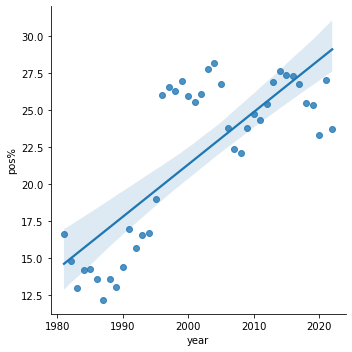

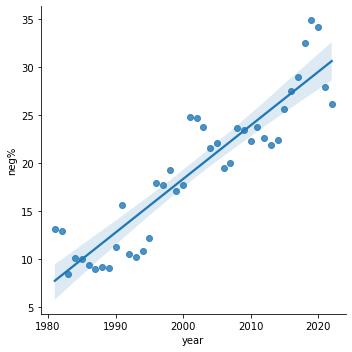

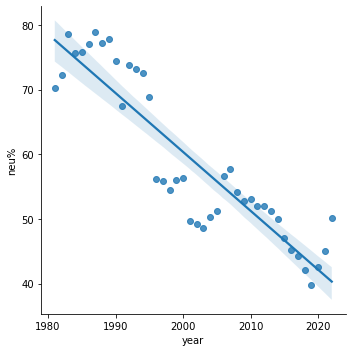

In [243]:
#Business Day: 
sns.lmplot('year', 'pos%', data=merged_biz_dd)
sns.lmplot('year', 'neg%', data=merged_biz_dd)
sns.lmplot('year', 'neu%', data=merged_biz_dd)

Graphing some of the trend lines for a news section that *don't* validate the hypothesis:

/Users/Jane/opt/anaconda3/envs/Python3X/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jane/opt/anaconda3/envs/Python3X/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/Jane/opt/anaconda3/envs/Python3X/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

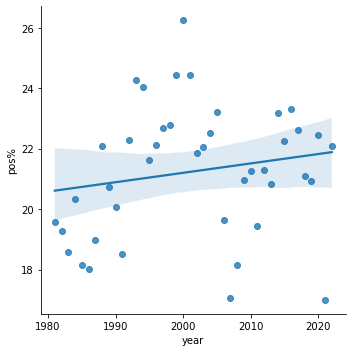

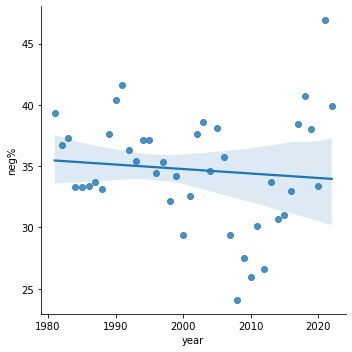

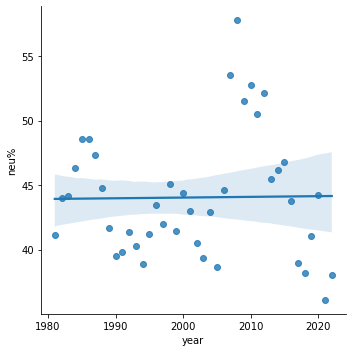

In [244]:
sns.lmplot('year', 'pos%', data=merged_usa_dd)
sns.lmplot('year', 'neg%', data=merged_usa_dd)
sns.lmplot('year', 'neu%', data=merged_usa_dd)

In [245]:
# continuing regression analysis for lifestyle news:


# Arts results
X_art_neu = merged_art_dd['year'] # independent
y_art_neu = merged_art_dd['neu%'] # dependent

X_art_pos = merged_art_dd['year'] # independent
y_art_pos = merged_art_dd['pos%'] # dependent

X_art_neg = merged_art_dd['year'] # independent
y_art_neg = merged_art_dd['neg%'] # dependent


# Books results
X_bks_neu = merged_bks_dd['year'] # independent
y_bks_neu = merged_bks_dd['neu%'] # dependent

X_bks_pos = merged_bks_dd['year'] # independent
y_bks_pos = merged_bks_dd['pos%'] # dependent

X_bks_neg = merged_bks_dd['year'] # independent
y_bks_neg = merged_bks_dd['neg%'] # dependent


# Sports results
X_spr_neu = merged_spr_dd['year'] # independent
y_spr_neu = merged_spr_dd['neu%'] # dependent

X_spr_pos = merged_spr_dd['year'] # independent
y_spr_pos = merged_spr_dd['pos%'] # dependent

X_spr_neg = merged_spr_dd['year'] # independent
y_spr_neg = merged_spr_dd['neg%'] # dependent


# Style Day results
X_sty_neu = merged_sty_dd['year'] # independent
y_sty_neu = merged_sty_dd['neu%'] # dependent

X_sty_pos = merged_sty_dd['year'] # independent
y_sty_pos = merged_sty_dd['pos%'] # dependent

X_sty_neg = merged_sty_dd['year'] # independent
y_sty_neg = merged_sty_dd['neg%'] # dependent


# Movies results
X_mvs_neu = merged_mvs_dd['year'] # independent
y_mvs_neu = merged_mvs_dd['neu%'] # dependent

X_mvs_pos = merged_mvs_dd['year'] # independent
y_mvs_pos = merged_mvs_dd['pos%'] # dependent

X_mvs_neg = merged_mvs_dd['year'] # independent
y_mvs_neg = merged_mvs_dd['neg%'] # dependent


print('Arts results:')
print(f'Neutral trend:{stats.pearsonr(X_art_neu,y_art_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_art_pos,y_art_pos)}')
print(f'Negative trend:{stats.pearsonr(X_art_neg,y_art_neg)}')

print('Books results:')
print(f'Neutral trend:{stats.pearsonr(X_bks_neu,y_bks_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_bks_pos,y_bks_pos)}')
print(f'Negative trend:{stats.pearsonr(X_bks_neg,y_bks_neg)}')

print('Sports results:')
print(f'Neutral trend:{stats.pearsonr(X_spr_neu,y_spr_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_spr_pos,y_spr_pos)}')
print(f'Negative trend:{stats.pearsonr(X_spr_neg,y_spr_neg)}')

print('Style results:')
print(f'Neutral trend:{stats.pearsonr(X_sty_neu,y_sty_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_sty_pos,y_sty_pos)}')
print(f'Negative trend:{stats.pearsonr(X_sty_neg,y_sty_neg)}')

print('Movies results:')
print(f'Neutral trend:{stats.pearsonr(X_mvs_neu,y_mvs_neu)}') 
print(f'Positive trend:{stats.pearsonr(X_mvs_pos,y_mvs_pos)}')
print(f'Negative trend:{stats.pearsonr(X_mvs_neg,y_mvs_neg)}')

Arts results:
Neutral trend:(-0.6712483723346581, 1.1419625372143216e-06)
Positive trend:(0.5380787202073878, 0.00023753622774546246)
Negative trend:(0.7186201530169516, 8.354817691084106e-08)
Books results:
Neutral trend:(-0.14757133407496503, 0.35101128174669477)
Positive trend:(-0.03710400292515885, 0.8155402041885313)
Negative trend:(0.3727195649242341, 0.015060903700024927)
Sports results:
Neutral trend:(-0.7326998185104328, 3.4609759556905326e-08)
Positive trend:(0.8520664262676703, 8.286406287554082e-13)
Negative trend:(0.2912244393776983, 0.061320256564610924)
Style results:
Neutral trend:(-0.6598302355270494, 2.0017337151435008e-06)
Positive trend:(0.7957830714595675, 3.009605207619059e-10)
Negative trend:(0.08860416462829293, 0.5768506494328334)
Movies results:
Neutral trend:(-0.1566121500464508, 0.3219484597490047)
Positive trend:(-0.19909849932572116, 0.20620619135232093)
Negative trend:(0.48173602950082073, 0.0012371946432881368)


Trend Validation:

`Arts` --> hypothesis validate across the board.
* Net neutral headline share falling by 2/3pp each year, stat. sig.
* Net positive headline share growing by 1/2pp and net negative headline share growing by 3/4pp each year, both stat. sig.!

`Sports` & `Style` news --> validating positive replacing neutral: 
* Neutral declining by .6pp for `Style` and .7pp for `Sports` per year, stat. sig!
* Positive growing by about .8pp for each per year, also stat. sig!
* Negative trend not stat. sig. for either section of news

`Movies` & `Books` --> only negative growing trend is stat. sig. does not truly validate the hypothesis.
* `Movies` net negative headline share growing by about 1/2pp each year
* `Books` net negative headline share growing by about 1/3 pp each year

## Section 7: Analysis II (Single Section Deep Dive & Vectorization)

Using `World` as an example as it partially validates my hypothesis and is a relatable, tangible section for working with / sampling. This is also historically the least neutral and most negative section of news, as visualized in Tableau workbook & presentation.

`Business Day` would have been potentially been better but I did not want the project to take on a kind of pragmatic business-oriented tone, nor did I want to get distracted investigating the almost too-steep fluctuations in this category. I did not want to use `Art` (another section that completely validated the hypothesis) because I wanted to stick to traditional, relatable news sections.

#### Overall `scorecard` / high-level views:


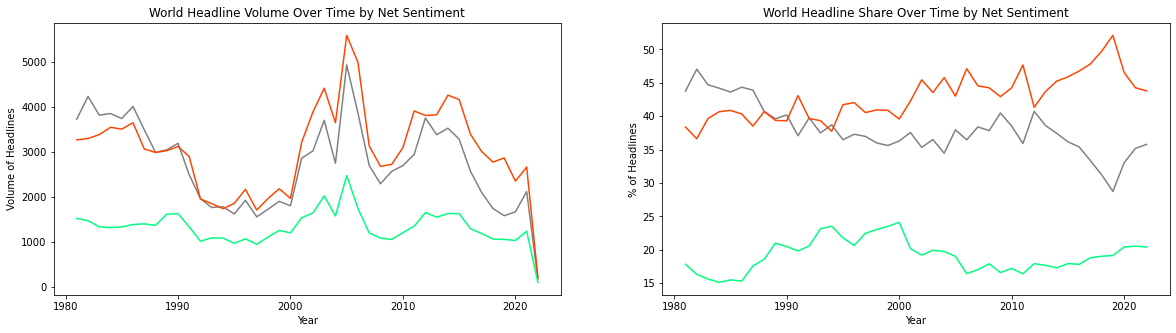

In [246]:
#plotting overall views of volume & % shares

plt.subplots(1,2, figsize=(20,5))

#plotting volume columns
plt.subplot(1,2,1)
merged_wrl_dd = sentiment_counts[sentiment_counts['section_name']=='World']
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['count_neu'], c='grey')
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['count_pos'], c='springgreen')
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['count_neg'], c='orangered')
plt.xlabel('Year')
plt.ylabel('Volume of Headlines')
plt.title('World Headline Volume Over Time by Net Sentiment')

#plotting share columns
plt.subplot(1,2,2)
merged_wrl_dd = sentiment_counts[sentiment_counts['section_name']=='World']
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['neu%'], c='grey')
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['pos%'], c='springgreen')
plt.plot(merged_wrl_dd['year'], merged_wrl_dd['neg%'], c='orangered')
plt.xlabel('Year')
plt.ylabel('% of Headlines')
plt.title('World Headline Share Over Time by Net Sentiment')

plt.show()

In [247]:
#creating World-specific df
df_world = df_all[df_all['section_name']=='World'].reset_index(drop=True)

In [248]:
df_world.shape

(297970, 11)

In [249]:
df_world.to_csv('World.csv', index=False)
#push World df to csv!

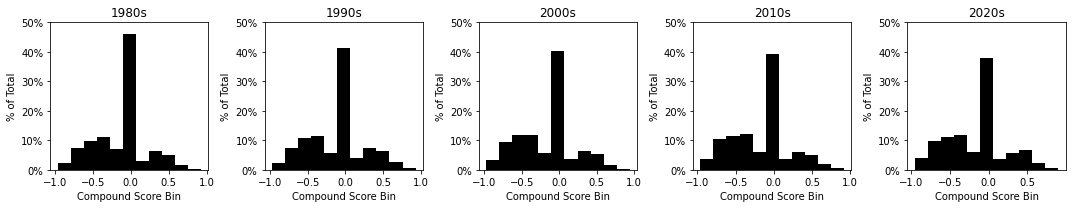

In [250]:
#graphing compound score distribution histograms for only `World`

plt.subplots(1,5, figsize=(15,3))

world1 = df_world[df_world['decade']==1]['compound']
world2 = df_world[df_world['decade']==2]['compound']
world3 = df_world[df_world['decade']==3]['compound']
world4 = df_world[df_world['decade']==4]['compound']
world5 = df_world[df_world['decade']==5]['compound']

from matplotlib.ticker import PercentFormatter

plt.subplot(1,5,1)
plt.hist(world1, weights=np.ones(len(world1))/len(world1),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('1980s')
plt.ylim([0,0.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,2)
plt.hist(world2, weights=np.ones(len(world2))/len(world2),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('1990s')
plt.ylim([0,0.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,3)
plt.hist(world3, weights=np.ones(len(world3))/len(world3),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('2000s')
plt.ylim([0,0.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,4)
plt.hist(world4, weights=np.ones(len(world4))/len(world4),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('2010s')
plt.ylim([0,0.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.subplot(1,5,5)
plt.hist(world5, weights=np.ones(len(world5))/len(world5),bins=11, color='black')
plt.xlabel('Compound Score Bin')
plt.ylabel('% of Total')
plt.title('2020s')
plt.ylim([0,0.5])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.show()

From these top-level views we can see:
* There have always been dramatically more Negative and Neutral headlines over the years, and they have actually fluctuated together in volume
* Negative headline share actually outweighs net neutral in the 90s, which is very interestingly true of only this single sectino of news, as seen in Tableau & presentation.
* Sentiment shifts to the negative side of the compound score distribution over the decades, as our regression analysis showed 

#### Vectorizing / tokenizing `World` data:


_Note: the following part of the work I consider more of a WIP / kick-off point, I need to continue to work with this data to make it into something meaningful, but I wanted to practice some of the more traditional NLP work that we had learned in class and addd to it to the scorecard concept (where someone who trace language changes in a section of news over time)._

_This is the part of the work where I think things have potential to get very interesting from the perspective of understanding the quality and character of language being used, but it's heavier / longer-term lift._

In [251]:
#breaking this df into individual groups of 5 years

#2020-2021
df_world_9 = df_world[df_world['year_group']==9].drop(columns=['year','month','year_group','section_name','decade'])
df_world_9 = df_world_9.reset_index(drop=True)

#2015-2019
df_world_8 = df_world[df_world['year_group']==8].drop(columns=['year','month','year_group','section_name','decade'])
df_world_8 = df_world_8.reset_index(drop=True)

#2010-2014
df_world_7 = df_world[df_world['year_group']==7].drop(columns=['year','month','year_group','section_name','decade'])
df_world_7 = df_world_7.reset_index(drop=True)

#2005-2009
df_world_6 = df_world[df_world['year_group']==6].drop(columns=['year','month','year_group','section_name','decade'])
df_world_6 = df_world_6.reset_index(drop=True)

#2000-2004
df_world_5 = df_world[df_world['year_group']==5].drop(columns=['year','month','year_group','section_name','decade'])
df_world_5 = df_world_5.reset_index(drop=True)

#1995-1999
df_world_4 = df_world[df_world['year_group']==4].drop(columns=['year','month','year_group','section_name','decade'])
df_world_4 = df_world_4.reset_index(drop=True)

#1990-1994
df_world_3 = df_world[df_world['year_group']==3].drop(columns=['year','month','year_group','section_name','decade'])
df_world_3 = df_world_3.reset_index(drop=True)

#1984-1989
df_world_2 = df_world[df_world['year_group']==2].drop(columns=['year','month','year_group','section_name','decade'])
df_world_2 = df_world_2.reset_index(drop=True)

#1981-1984
df_world_1 = df_world[df_world['year_group']==1].drop(columns=['year','month','year_group','section_name','decade'])
df_world_1 = df_world_1.reset_index(drop=True)

In [252]:
#taking a look at just one of these  
df_world_9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11528 entries, 0 to 11527
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   headline  11528 non-null  object 
 1   compound  11528 non-null  float64
 2   neg       11528 non-null  float64
 3   neu       11528 non-null  float64
 4   pos       11528 non-null  float64
 5   score     11528 non-null  object 
dtypes: float64(4), object(2)
memory usage: 540.5+ KB


In [253]:
#breaking this df into the headlines with top 1000 compound scores, and bottom 1000 compound scores
df_world_9_top = df_world_9.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_9_bottom = df_world_9.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

_note: I tried vectorizing the individual dfs (`df_world_9`) and even the entire `df_world` but could not vectorize from there, my kernel would instantly shut down, another reason I am breaking this down in so many ways (by year, top score, etc.)_

In [254]:
#vectorizing the top and bottom 1K headlines
from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_9_bottom = CountVectorizer(stop_words="english")
bagofwords_world_9_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_9_bottom.fit(df_world_9_bottom['headline'])
bagofwords_world_9_top.fit(df_world_9_top['headline'])

#transform
world_9_bottom_transformed = bagofwords_world_9_bottom.transform(df_world_9_bottom['headline'])
world_9_top_transformed = bagofwords_world_9_top.transform(df_world_9_top['headline'])

In [255]:
#converting to array
world_9_bottom_transformed.toarray()
world_9_top_transformed.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [256]:
#turn sparse matrix into array and then df
df_world_9_bottom_vectors = pd.DataFrame(columns = bagofwords_world_9_bottom.get_feature_names_out(), data = world_9_bottom_transformed.toarray())
df_world_9_top_vectors = pd.DataFrame(columns = bagofwords_world_9_top.get_feature_names_out(), data = world_9_top_transformed.toarray())

In [257]:
#final vectorized dfs representing bottom and top 1K headlines (by compound score):
df_world_vectorized_9_bottom = pd.concat([df_world_9_bottom, df_world_9_bottom_vectors], axis=1)
df_world_vectorized_9_top = pd.concat([df_world_9_top, df_world_9_top_vectors], axis=1)

In [258]:
#splitting into X & y for coefficient / counting:
X_world_9_bottom = df_world_vectorized_9_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_9_bottom = df_world_vectorized_9_bottom['compound']

X_world_9_top = df_world_vectorized_9_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_9_top = df_world_vectorized_9_top['compound']

Repeat for all other `year_groups`:

In [259]:
df_world_2_top = df_world_2.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_2_bottom = df_world_2.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_2_bottom = CountVectorizer(stop_words="english")
bagofwords_world_2_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_2_bottom.fit(df_world_2_bottom['headline'])
bagofwords_world_2_top.fit(df_world_2_top['headline'])

#transform
world_2_bottom_transformed = bagofwords_world_2_bottom.transform(df_world_2_bottom['headline'])
world_2_top_transformed = bagofwords_world_2_top.transform(df_world_2_top['headline'])

#converting to array
world_2_bottom_transformed.toarray()
world_2_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_2_bottom_vectors = pd.DataFrame(columns = bagofwords_world_2_bottom.get_feature_names_out(), data = world_2_bottom_transformed.toarray())
df_world_2_top_vectors = pd.DataFrame(columns = bagofwords_world_2_top.get_feature_names_out(), data = world_2_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_2_bottom = pd.concat([df_world_2_bottom, df_world_2_bottom_vectors], axis=1)
df_world_vectorized_2_top = pd.concat([df_world_2_top, df_world_2_top_vectors], axis=1)

X_world_2_bottom = df_world_vectorized_2_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_2_bottom = df_world_vectorized_2_bottom['compound']

X_world_2_top = df_world_vectorized_2_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_2_top = df_world_vectorized_2_top['compound']


In [260]:
df_world_3_top = df_world_3.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_3_bottom = df_world_3.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_3_bottom = CountVectorizer(stop_words="english")
bagofwords_world_3_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_3_bottom.fit(df_world_3_bottom['headline'])
bagofwords_world_3_top.fit(df_world_3_top['headline'])

#transform
world_3_bottom_transformed = bagofwords_world_3_bottom.transform(df_world_3_bottom['headline'])
world_3_top_transformed = bagofwords_world_3_top.transform(df_world_3_top['headline'])

#converting to array
world_3_bottom_transformed.toarray()
world_3_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_3_bottom_vectors = pd.DataFrame(columns = bagofwords_world_3_bottom.get_feature_names_out(), data = world_3_bottom_transformed.toarray())
df_world_3_top_vectors = pd.DataFrame(columns = bagofwords_world_3_top.get_feature_names_out(), data = world_3_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_3_bottom = pd.concat([df_world_3_bottom, df_world_3_bottom_vectors], axis=1)
df_world_vectorized_3_top = pd.concat([df_world_3_top, df_world_3_top_vectors], axis=1)

X_world_3_bottom = df_world_vectorized_3_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_3_bottom = df_world_vectorized_3_bottom['compound']

X_world_3_top = df_world_vectorized_3_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_3_top = df_world_vectorized_3_top['compound']



In [261]:
df_world_4_top = df_world_4.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_4_bottom = df_world_4.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_4_bottom = CountVectorizer(stop_words="english")
bagofwords_world_4_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_4_bottom.fit(df_world_4_bottom['headline'])
bagofwords_world_4_top.fit(df_world_4_top['headline'])

#transform
world_4_bottom_transformed = bagofwords_world_4_bottom.transform(df_world_4_bottom['headline'])
world_4_top_transformed = bagofwords_world_4_top.transform(df_world_4_top['headline'])

#converting to array
world_4_bottom_transformed.toarray()
world_4_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_4_bottom_vectors = pd.DataFrame(columns = bagofwords_world_4_bottom.get_feature_names_out(), data = world_4_bottom_transformed.toarray())
df_world_4_top_vectors = pd.DataFrame(columns = bagofwords_world_4_top.get_feature_names_out(), data = world_4_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_4_bottom = pd.concat([df_world_4_bottom, df_world_4_bottom_vectors], axis=1)
df_world_vectorized_4_top = pd.concat([df_world_4_top, df_world_4_top_vectors], axis=1)

X_world_4_bottom = df_world_vectorized_4_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_4_bottom = df_world_vectorized_4_bottom['compound']

X_world_4_top = df_world_vectorized_4_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_4_top = df_world_vectorized_4_top['compound']

In [262]:
df_world_5_top = df_world_5.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_5_bottom = df_world_5.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_5_bottom = CountVectorizer(stop_words="english")
bagofwords_world_5_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_5_bottom.fit(df_world_5_bottom['headline'])
bagofwords_world_5_top.fit(df_world_5_top['headline'])

#transform
world_5_bottom_transformed = bagofwords_world_5_bottom.transform(df_world_5_bottom['headline'])
world_5_top_transformed = bagofwords_world_5_top.transform(df_world_5_top['headline'])

#converting to array
world_5_bottom_transformed.toarray()
world_5_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_5_bottom_vectors = pd.DataFrame(columns = bagofwords_world_5_bottom.get_feature_names_out(), data = world_5_bottom_transformed.toarray())
df_world_5_top_vectors = pd.DataFrame(columns = bagofwords_world_5_top.get_feature_names_out(), data = world_5_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_5_bottom = pd.concat([df_world_5_bottom, df_world_5_bottom_vectors], axis=1)
df_world_vectorized_5_top = pd.concat([df_world_5_top, df_world_5_top_vectors], axis=1)

X_world_5_bottom = df_world_vectorized_5_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_5_bottom = df_world_vectorized_5_bottom['compound']

X_world_5_top = df_world_vectorized_5_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_5_top = df_world_vectorized_5_top['compound']

In [263]:
df_world_6_top = df_world_6.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_6_bottom = df_world_6.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_6_bottom = CountVectorizer(stop_words="english")
bagofwords_world_6_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_6_bottom.fit(df_world_6_bottom['headline'])
bagofwords_world_6_top.fit(df_world_6_top['headline'])

#transform
world_6_bottom_transformed = bagofwords_world_6_bottom.transform(df_world_6_bottom['headline'])
world_6_top_transformed = bagofwords_world_6_top.transform(df_world_6_top['headline'])

#converting to array
world_6_bottom_transformed.toarray()
world_6_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_6_bottom_vectors = pd.DataFrame(columns = bagofwords_world_6_bottom.get_feature_names_out(), data = world_6_bottom_transformed.toarray())
df_world_6_top_vectors = pd.DataFrame(columns = bagofwords_world_6_top.get_feature_names_out(), data = world_6_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_6_bottom = pd.concat([df_world_6_bottom, df_world_6_bottom_vectors], axis=1)
df_world_vectorized_6_top = pd.concat([df_world_6_top, df_world_6_top_vectors], axis=1)

X_world_6_bottom = df_world_vectorized_6_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_6_bottom = df_world_vectorized_6_bottom['compound']

X_world_6_top = df_world_vectorized_6_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_6_top = df_world_vectorized_6_top['compound']

In [264]:
df_world_7_top = df_world_7.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_7_bottom = df_world_7.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_7_bottom = CountVectorizer(stop_words="english")
bagofwords_world_7_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_7_bottom.fit(df_world_7_bottom['headline'])
bagofwords_world_7_top.fit(df_world_7_top['headline'])

#transform
world_7_bottom_transformed = bagofwords_world_7_bottom.transform(df_world_7_bottom['headline'])
world_7_top_transformed = bagofwords_world_7_top.transform(df_world_7_top['headline'])

#converting to array
world_7_bottom_transformed.toarray()
world_7_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_7_bottom_vectors = pd.DataFrame(columns = bagofwords_world_7_bottom.get_feature_names_out(), data = world_7_bottom_transformed.toarray())
df_world_7_top_vectors = pd.DataFrame(columns = bagofwords_world_7_top.get_feature_names_out(), data = world_7_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_7_bottom = pd.concat([df_world_7_bottom, df_world_7_bottom_vectors], axis=1)
df_world_vectorized_7_top = pd.concat([df_world_7_top, df_world_7_top_vectors], axis=1)

X_world_7_bottom = df_world_vectorized_7_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_7_bottom = df_world_vectorized_7_bottom['compound']

X_world_7_top = df_world_vectorized_7_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_7_top = df_world_vectorized_7_top['compound']

In [265]:
df_world_8_top = df_world_8.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_8_bottom = df_world_8.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_8_bottom = CountVectorizer(stop_words="english")
bagofwords_world_8_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_8_bottom.fit(df_world_8_bottom['headline'])
bagofwords_world_8_top.fit(df_world_8_top['headline'])

#transform
world_8_bottom_transformed = bagofwords_world_8_bottom.transform(df_world_8_bottom['headline'])
world_8_top_transformed = bagofwords_world_8_top.transform(df_world_8_top['headline'])

#converting to array
world_8_bottom_transformed.toarray()
world_8_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_8_bottom_vectors = pd.DataFrame(columns = bagofwords_world_8_bottom.get_feature_names_out(), data = world_8_bottom_transformed.toarray())
df_world_8_top_vectors = pd.DataFrame(columns = bagofwords_world_8_top.get_feature_names_out(), data = world_8_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_8_bottom = pd.concat([df_world_8_bottom, df_world_8_bottom_vectors], axis=1)
df_world_vectorized_8_top = pd.concat([df_world_8_top, df_world_8_top_vectors], axis=1)

X_world_8_bottom = df_world_vectorized_8_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_8_bottom = df_world_vectorized_8_bottom['compound']

X_world_8_top = df_world_vectorized_8_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_8_top = df_world_vectorized_8_top['compound']

In [266]:
df_world_1_top = df_world_1.sort_values('compound',ascending=False).reset_index(drop=True).head(1000)
df_world_1_bottom = df_world_1.sort_values('compound',ascending=True).reset_index(drop=True).head(1000)

from sklearn.feature_extraction.text import CountVectorizer

#instantiate
bagofwords_world_1_bottom = CountVectorizer(stop_words="english")
bagofwords_world_1_top = CountVectorizer(stop_words="english")

#fit
bagofwords_world_1_bottom.fit(df_world_1_bottom['headline'])
bagofwords_world_1_top.fit(df_world_1_top['headline'])

#transform
world_1_bottom_transformed = bagofwords_world_1_bottom.transform(df_world_1_bottom['headline'])
world_1_top_transformed = bagofwords_world_1_top.transform(df_world_1_top['headline'])

#converting to array
world_1_bottom_transformed.toarray()
world_1_top_transformed.toarray()

#turn sparse matrix into array and then df
df_world_1_bottom_vectors = pd.DataFrame(columns = bagofwords_world_1_bottom.get_feature_names_out(), data = world_1_bottom_transformed.toarray())
df_world_1_top_vectors = pd.DataFrame(columns = bagofwords_world_1_top.get_feature_names_out(), data = world_1_top_transformed.toarray())

#joining vectorized df to original df
df_world_vectorized_1_bottom = pd.concat([df_world_1_bottom, df_world_1_bottom_vectors], axis=1)
df_world_vectorized_1_top = pd.concat([df_world_1_top, df_world_1_top_vectors], axis=1)

X_world_1_bottom = df_world_vectorized_1_bottom.drop(columns=['headline','compound','neu','pos','neg'])
y_world_1_bottom = df_world_vectorized_1_bottom['compound']

X_world_1_top = df_world_vectorized_1_top.drop(columns=['headline','compound','neu','pos','neg'])
y_world_1_top = df_world_vectorized_1_top['compound']

#### Identifying top / bottom tokens:

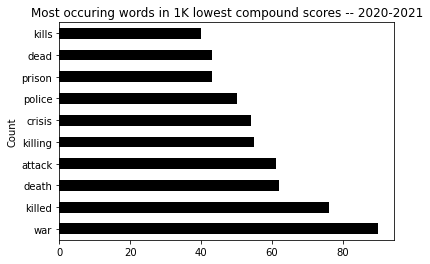

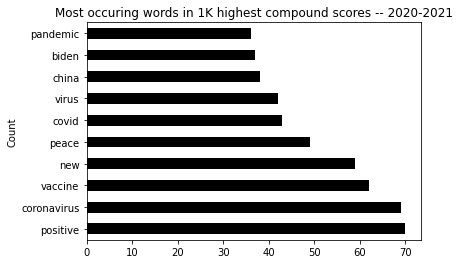

In [267]:
#graphing token counts:

word_counts_neg = pd.DataFrame(
    {"counts": X_world_9_bottom.sum(axis=0)},
    index=bagofwords_world_9_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_9_top.sum(axis=0)},
    index=bagofwords_world_9_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 2020-2021")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 2020-2021")
plt.ylabel("Count")

plt.show()

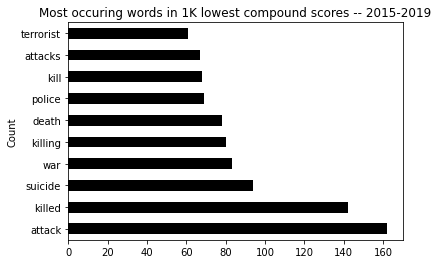

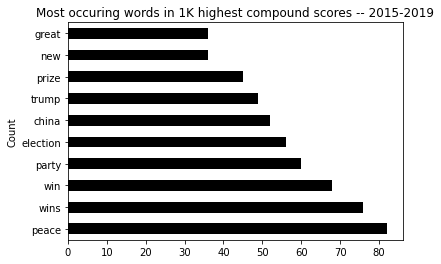

In [268]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_8_bottom.sum(axis=0)},
    index=bagofwords_world_8_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_8_top.sum(axis=0)},
    index=bagofwords_world_8_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 2015-2019")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 2015-2019")
plt.ylabel("Count")

plt.show()

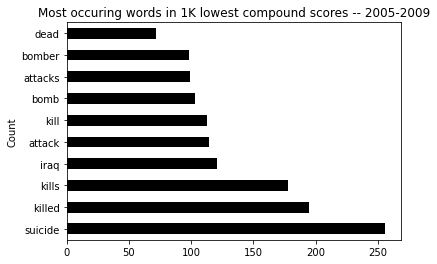

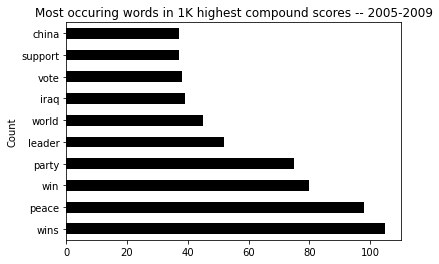

In [269]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_6_bottom.sum(axis=0)},
    index=bagofwords_world_6_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_6_top.sum(axis=0)},
    index=bagofwords_world_6_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 2005-2009")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 2005-2009")
plt.ylabel("Count")

plt.show()

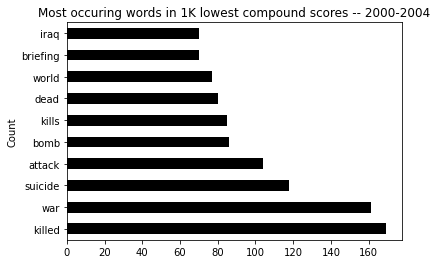

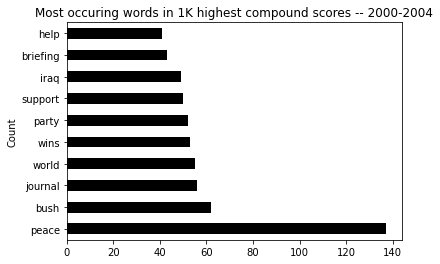

In [270]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_5_bottom.sum(axis=0)},
    index=bagofwords_world_5_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_5_top.sum(axis=0)},
    index=bagofwords_world_5_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 2000-2004")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 2000-2004")
plt.ylabel("Count")

plt.show()

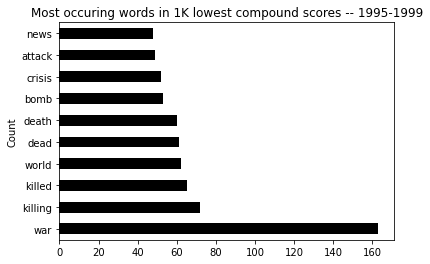

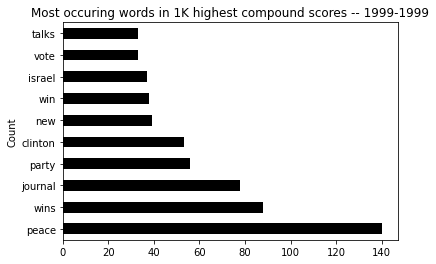

In [271]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_4_bottom.sum(axis=0)},
    index=bagofwords_world_4_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_4_top.sum(axis=0)},
    index=bagofwords_world_4_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 1995-1999")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 1999-1999")
plt.ylabel("Count")

plt.show()

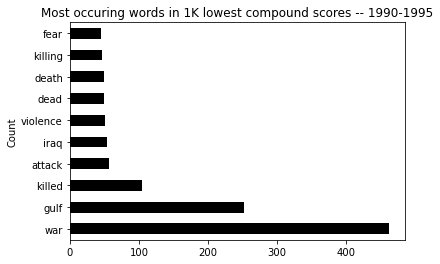

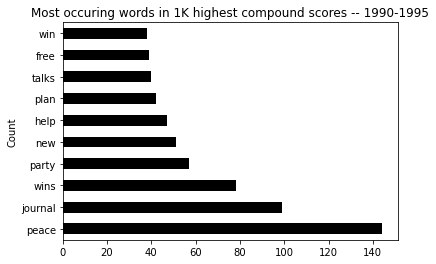

In [272]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_3_bottom.sum(axis=0)},
    index=bagofwords_world_3_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_3_top.sum(axis=0)},
    index=bagofwords_world_3_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 1990-1995")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 1990-1995")
plt.ylabel("Count")

plt.show()

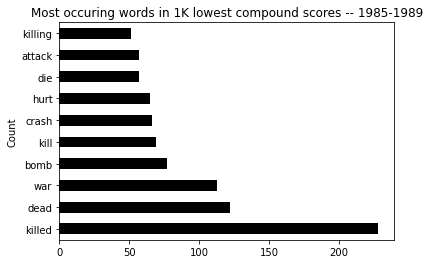

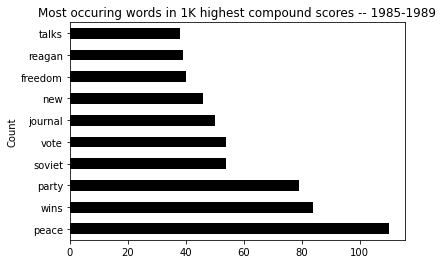

In [273]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_2_bottom.sum(axis=0)},
    index=bagofwords_world_2_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_2_top.sum(axis=0)},
    index=bagofwords_world_2_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 1985-1989")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 1985-1989")
plt.ylabel("Count")

plt.show()

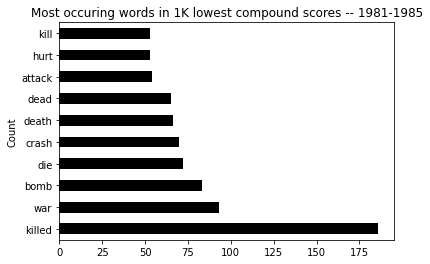

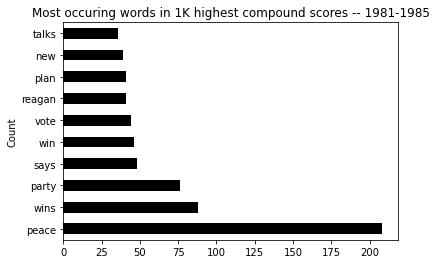

In [274]:
word_counts_neg = pd.DataFrame(
    {"counts": X_world_1_bottom.sum(axis=0)},
    index=bagofwords_world_1_bottom.get_feature_names_out()
).sort_values("counts", ascending=False)

word_counts_pos = pd.DataFrame(
    {"counts": X_world_1_top.sum(axis=0)},
    index=bagofwords_world_1_top.get_feature_names_out()
).sort_values("counts", ascending=False)


word_counts_neg.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K lowest compound scores -- 1981-1985")
plt.ylabel("Count")

word_counts_pos.head(10).plot(kind="barh", legend=False, color='black')
plt.title("Most occuring words in 1K highest compound scores -- 1981-1985")
plt.ylabel("Count")

plt.show()

#### Identifying top / bottom headlines:

In [275]:
df_world_9_bottom.head(5)

,headline,compound,neg,neu,pos,score
0,"Murder, Torture, Rape: A Landmark Conviction on State Violence in Syria",-0.9590,0.704,0.243,0.053,negative
1,Toronto Van Attacker Found Guilty in City’s Worst Mass Killing,-0.9432,0.714,0.286,0.000,negative
2,Longtime U.K. Lawmaker Stabbed to Death in Attack Labeled Terrorism,-0.9382,0.707,0.293,0.000,negative
3,At Front Lines of a Brutal War: Death and Despair in Nagorno-Karabakh,-0.9349,0.640,0.360,0.000,negative
4,"After Nagorno-Karabakh War, Trauma, Tragedy and Devastation",-0.9313,0.822,0.178,0.000,negative


In [276]:
df_world_9_top.head(5)

,headline,compound,neg,neu,pos,score
0,China’s answer to Dr. Fauci wins hearts with candor and respect.,0.9022,0.00,0.419,0.581,positive
1,Maria Ressa is only the 18th woman to win the Nobel Peace Prize in its 126-year history.,0.8910,0.00,0.569,0.431,positive
2,Russia Was Ready to Celebrate a Glorious Past. The Present Intervened.,0.8860,0.00,0.435,0.565,positive
3,Sisi Promised Egypt Better Health Care. Virus Exposed His True Priority.,0.8779,0.07,0.321,0.610,positive
4,"Denuded of Tourists, Paris Reveals Its Old Beating Heart",0.8750,0.00,0.438,0.562,positive


In [277]:
df_world_8_top.head(5)

,headline,compound,neg,neu,pos,score
0,"Elie Wiesel, Auschwitz Survivor and Nobel Peace Prize Winner, Dies at 87",0.9201,0.0,0.379,0.621,positive
1,"Indians, Some Seeking Brighter Fortunes, Celebrate Vibrant Ganesh Festival",0.9169,0.0,0.279,0.721,positive
2,"Cease-Fire in Syria Frays but Holds, Giving Hope to Peace Talks",0.9136,0.0,0.406,0.594,positive
3,Great Journalism Made Better With a Great (International) Audience,0.9022,0.0,0.351,0.649,positive
4,Dog Earns Special Treat: British Award for Bravery,0.9022,0.0,0.248,0.752,positive


In [278]:
df_world_8_bottom.head(5)

,headline,compound,neg,neu,pos,score
0,"Pakistan Serial Killer Sentenced to Death for Murder and Rape of Girl, 7",-0.9623,0.700,0.300,0.0,negative
1,Suicide Attackers Kill 19 in Assault on a Shiite Mosque in Pakistan,-0.9565,0.676,0.324,0.0,negative
2,"After Horrific Rape in India, Police Kill 4 Suspects",-0.9531,0.764,0.236,0.0,negative
3,Jewish Man Stabbed by Fellow Israeli in Botched Revenge Attack Denounces Ethnic Violence,-0.9468,0.672,0.328,0.0,negative
4,"Military Plane Crash Is Algeria’s Worst Air Disaster, With 257 Dead",-0.9451,0.685,0.315,0.0,negative


^^^ repeat above on different dfs (by swapping out #) to grab headlines for each year group for presentation.

# End